# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-04-06 13:02:35,984 fedbiomed INFO - Component environment:
2022-04-06 13:02:35,986 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-04-06 13:02:37,498 fedbiomed INFO - Messaging researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x105d46640>
2022-04-06 13:02:37,526 fedbiomed INFO - Listing available datasets in all nodes... 
2022-04-06 13:02:37,537 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'command': 'list'}
2022-04-06 13:02:37,541 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'command': 'list'}
2022-04-06 13:02:37,548 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Message received: {'researcher_id': 'resea

{'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}],
 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}],
 'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [16954, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [4]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List
from opacus.validators import ModuleValidator
#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import monai",
                "from torch.nn import MSELoss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from opacus.validators import ModuleValidator"]
        self.add_dependency(deps)
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
        
        if (('DP' in model_args) and (model_args['DP']==True)):
            self.validate_and_fix_model()
            
        self.optimizer = torch.optim.Adam(self.model.parameters(), 1e-5)

    def validate_and_fix_model(self):
        # Validate and Fix model to be DP-compliant
        if not ModuleValidator.is_valid(self.model):
            print('######################################## Fixing Model ########################################')
            self.model = ModuleValidator.fix(self.model)

    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl, batch_size=batch_size, shuffle=True, num_workers=0)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [6]:
model_args = {'use_gpu': True}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 3, 
    'dry_run': False,  
    'batch_maxnum':250 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['mednist']
rounds = 5

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [7]:
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-04-06 13:02:53,959 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
04/06/2022 13:02:53:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-04-06 13:02:53,988 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
04/06/2022 13:02:53:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
2022-04-06 13:02:53,994 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
04/06/2022 13:02:53:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [8]:
exp.run()

2022-04-06 13:03:05,755 fedbiomed INFO - Sampled nodes in round 0 ['node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb']
04/06/2022 13:03:05:INFO:Sampled nodes in round 0 ['node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb']
2022-04-06 13:03:05,759 fedbiomed INFO - Send message to node node_2b22d100-8d28-471c-a4b0-55e1573a7d9e - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4

04/06/2022 13:03:05:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_init_e2e0ca70-1e89-4518-8d90-670b96629724.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}}
2022-04-06 13:03:05,828 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0

2022-04-06 13:03:05,973 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - upload (HTTP GET request) of file my_model_16d331eeb10245c78b7a9feb38aeec5e.py successful, with status code 200
04/06/2022 13:03:05:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - upload (HTTP GET request) of file my_model_16d331eeb10245c78b7a9feb38aeec5e.py successful, with status code 200
2022-04-06 13:03:05,977 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_100ee0549a894fbaa6e87b2c16fa24bf.py successful, with status code 200
04/06/2022 13:03:05:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_100ee0549a894fbaa6e87b2c16fa24bf.py successful, with status code 200
2022-04-06 13:03:06,484 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_bd5cb217-6e4c-4c58-b043-21

2022-04-06 13:03:12,617 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/06/2022 13:03:12:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:03:13,878 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.078969
04/06/2022 13:03:13:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.078969
2022-04-06 13:03:13,910 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=0 Loss:0.07896944135427475
04/06/2022 13:03:13:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=0 Loss:0.07896944135427475
2022-04-06 13:03:13,928 fedbiomed INFO - log

2022-04-06 13:03:37,634 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [640/1000 (63%)]	Loss: 0.069559
04/06/2022 13:03:37:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [640/1000 (63%)]	Loss: 0.069559
2022-04-06 13:03:37,637 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=40 Loss:0.06955932825803757
04/06/2022 13:03:37:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=40 Loss:0.06955932825803757
2022-04-06 13:03:43,526 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.053778
04/06/2022 13:03:43:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.053778
2022-04-06 13:03:43,541 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=50 Loss:0.05377799645066261
04/06/2022 13:

04/06/2022 13:04:03:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=20 Loss:0.04981720447540283
2022-04-06 13:04:03,663 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [320/1000 (32%)]	Loss: 0.051918
04/06/2022 13:04:03:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [320/1000 (32%)]	Loss: 0.051918
2022-04-06 13:04:03,666 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=20 Loss:0.05191824957728386
04/06/2022 13:04:03:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=20 Loss:0.05191824957728386
2022-04-06 13:04:09,709 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.038636
04/06/2022 13:04:09:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.038636
2022-04-06 13:04:09,712 fedbio

2022-04-06 13:04:35,161 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=0 Loss:0.047520264983177185
04/06/2022 13:04:35:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=0 Loss:0.047520264983177185
2022-04-06 13:04:35,404 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.051205
04/06/2022 13:04:35:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.051205
2022-04-06 13:04:35,410 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=0 Loss:0.05120497941970825
04/06/2022 13:04:35:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=0 Loss:0.05120497941970825
2022-04-06 13:04:42,817 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.056794
04/06/2022 13:04:42:INFO:

04/06/2022 13:05:10:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.049867
2022-04-06 13:05:10,454 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.049866579473018646
04/06/2022 13:05:10:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.049866579473018646
2022-04-06 13:05:10,744 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.044699
04/06/2022 13:05:10:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.044699
2022-04-06 13:05:10,748 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=50 Loss:0.04469912499189377
04/06/2022 13:05:10:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=50 Loss:0.04469912499189377
2022-04-06 13:05:17,776 fedbiom

04/06/2022 13:05:26:INFO:Downloading model params after training on node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - from http://localhost:8844/media/uploads/2022/04/06/node_params_d523edfb-0379-4a60-a44a-8714d901cade.pt
2022-04-06 13:05:26,414 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_8c13e776-9704-494a-9fd2-6776a0a88838.pt successful, with status code 200
04/06/2022 13:05:26:DEBUG:upload (HTTP GET request) of file node_params_8c13e776-9704-494a-9fd2-6776a0a88838.pt successful, with status code 200
2022-04-06 13:05:26,454 fedbiomed INFO - Nodes that successfully reply in round 0 ['node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb', 'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556']
04/06/2022 13:05:26:INFO:Nodes that successfully reply in round 0 ['node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb', 'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556']
2022-04-06 13:05:26,854 fedbiomed DEBUG - upload (HTTP POS

04/06/2022 13:05:26:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_b903ea20-6b57-42ad-ba13-5b8241e6ebed.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training_data': {'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e': ['dataset_52fbf800-e61f-4c07-a238-dac67f2dab17']}, 'training': True, 'model_args': {'use_gpu': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-06 13:05:26,912 fedbiomed INFO - Send message to node node_42f70c32-f5f1-43d7-bebc-f

2022-04-06 13:05:26,985 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_b903ea20-6b57-42ad-ba13-5b8241e6ebed.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}, 'training': True, 'model_args': {'use_gpu': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/06/2022 13:05:26:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556

04/06/2022 13:05:30:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-06 13:05:30,801 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/06/2022 13:05:30:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:05:30,813 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13e4f1b80>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'ep

04/06/2022 13:05:50:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=30 Loss:0.04319535940885544
2022-04-06 13:05:50,669 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.053073
04/06/2022 13:05:50:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.053073
2022-04-06 13:05:50,672 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=30 Loss:0.053072527050971985
04/06/2022 13:05:50:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=30 Loss:0.053072527050971985
2022-04-06 13:05:56,813 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [640/1000 (63%)]	Loss: 0.049194
04/06/2022 13:05:56:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [640/1000 (63%)]	Loss: 0.049194
2022-04-06 13:05:56,816 fedb

2022-04-06 13:06:16,651 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=10 Loss:0.05010675638914108
04/06/2022 13:06:16:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=10 Loss:0.05010675638914108
2022-04-06 13:06:16,700 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.037071
04/06/2022 13:06:16:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.037071
2022-04-06 13:06:16,703 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=10 Loss:0.037070997059345245
04/06/2022 13:06:16:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=10 Loss:0.037070997059345245
2022-04-06 13:06:22,701 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [320/1000 (32%)]	Loss: 0.059188
04/06/2022 13:0

04/06/2022 13:06:47:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.036614
2022-04-06 13:06:47,492 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=60 Loss:0.036613933742046356
04/06/2022 13:06:47:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=60 Loss:0.036613933742046356
2022-04-06 13:06:47,566 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.042198
04/06/2022 13:06:47:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.042198
2022-04-06 13:06:47,569 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=60 Loss:0.04219849780201912
04/06/2022 13:06:47:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=60 Loss:0.04219849780201912
2022-04-06 13:06:48,940 fedbiom

2022-04-06 13:07:12,809 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.037588
04/06/2022 13:07:12:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.037588
2022-04-06 13:07:12,812 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=40 Loss:0.03758765012025833
04/06/2022 13:07:12:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=40 Loss:0.03758765012025833
2022-04-06 13:07:12,837 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.041150
04/06/2022 13:07:12:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.041150
2022-04-06 13:07:12,840 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=40 Loss:0.04114988446235657
04/06/2022 13:

2022-04-06 13:07:26,651 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - results uploaded successfully 
04/06/2022 13:07:26:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - results uploaded successfully 
2022-04-06 13:07:32,019 fedbiomed INFO - Downloading model params after training on node_2b22d100-8d28-471c-a4b0-55e1573a7d9e - from http://localhost:8844/media/uploads/2022/04/06/node_params_1fe5eabf-5e6e-4fde-ab77-5fa40e264a5b.pt
04/06/2022 13:07:32:INFO:Downloading model params after training on node_2b22d100-8d28-471c-a4b0-55e1573a7d9e - from http://localhost:8844/media/uploads/2022/04/06/node_params_1fe5eabf-5e6e-4fde-ab77-5fa40e264a5b.pt
2022-04-06 13:07:32,148 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_1a0fc86b-476e-4c71-9fc3-8e093bf94fa8.pt successful, with status code 200
04/06/2022 13:07:32:DEBUG:upload (HTTP GET request) of file node_params_1a0fc86b-476e-4c71-9fc3-8e093bf94fa8.pt successful, with status code 

04/06/2022 13:07:32:INFO:Send message to node node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_767950da-b5f0-4dbe-8059-b71c1dae6ef3.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}}
2022-04-06 13:07:32,822 fedbiomed DEBUG - researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
04/06/2022 13:07:3

2022-04-06 13:07:32,909 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_767950da-b5f0-4dbe-8059-b71c1dae6ef3.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}}
04/06/2022 13:07:32:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb 

04/06/2022 13:07:35:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-06 13:07:35,486 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/06/2022 13:07:35:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:07:35,494 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x139328ee0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'ep

04/06/2022 13:07:47:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=20 Loss:0.0389140285551548
2022-04-06 13:07:47,510 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.044175
04/06/2022 13:07:47:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.044175
2022-04-06 13:07:47,513 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=20 Loss:0.04417477548122406
04/06/2022 13:07:47:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=20 Loss:0.04417477548122406
2022-04-06 13:07:53,041 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.029203
04/06/2022 13:07:53:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.029203
2022-04-06 13:07:53,057 fedbiom

2022-04-06 13:08:13,072 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.03987254202365875
04/06/2022 13:08:13:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.03987254202365875
2022-04-06 13:08:13,106 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.042767
04/06/2022 13:08:13:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.042767
2022-04-06 13:08:13,109 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=0 Loss:0.04276660457253456
04/06/2022 13:08:13:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=0 Loss:0.04276660457253456
2022-04-06 13:08:19,080 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.047250
04/06/2022 13:08:19:INFO:lo

04/06/2022 13:08:42:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.038160
2022-04-06 13:08:42,832 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=50 Loss:0.038160406053066254
04/06/2022 13:08:42:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=50 Loss:0.038160406053066254
2022-04-06 13:08:42,872 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.045534
04/06/2022 13:08:42:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.045534
2022-04-06 13:08:42,875 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=50 Loss:0.045534372329711914
04/06/2022 13:08:42:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=50 Loss:0.045534372329711914
2022-04-06 13:08:48,842 fedbi

2022-04-06 13:09:08,270 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.035065
04/06/2022 13:09:08:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.035065
2022-04-06 13:09:08,273 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=30 Loss:0.03506474196910858
04/06/2022 13:09:08:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=30 Loss:0.03506474196910858
2022-04-06 13:09:08,434 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.036622
04/06/2022 13:09:08:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.036622
2022-04-06 13:09:08,436 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=30 Loss:0.036622025072574615
04/06/2022 13

2022-04-06 13:09:27,712 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - results uploaded successfully 
04/06/2022 13:09:27:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - results uploaded successfully 
2022-04-06 13:09:28,072 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_65f4770a-64c8-4fd9-a2fd-22da2d9aa026.pt successful, with status code 201
04/06/2022 13:09:28:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_65f4770a-64c8-4fd9-a2fd-22da2d9aa026.pt successful, with status code 201
2022-04-06 13:09:28,082 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - results uploaded successfully 
04/06/2022 13:09:28:INFO:log from: node_d2e9a85b-a64b-457

04/06/2022 13:09:38:INFO:Send message to node node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_c1c99f88-49ad-4e8d-a658-bc97af4549e2.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}}
2022-04-06 13:09:38,690 fedbiomed DEBUG - researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
04/06/2022 13:09:3

2022-04-06 13:09:38,742 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_c1c99f88-49ad-4e8d-a658-bc97af4549e2.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}}
04/06/2022 13:09:38:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb 

2022-04-06 13:09:39,128 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
04/06/2022 13:09:39:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
2022-04-06 13:09:39,138 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_2
04/06/2022 13:09:39:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_2
2022-04-06 13:09:41,506 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13fab4460>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_o

2022-04-06 13:09:47,707 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=10 Loss:0.051454294472932816
04/06/2022 13:09:47:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=10 Loss:0.051454294472932816
2022-04-06 13:09:47,754 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.045923
04/06/2022 13:09:47:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.045923
2022-04-06 13:09:47,757 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=10 Loss:0.045923441648483276
04/06/2022 13:09:47:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=10 Loss:0.045923441648483276
2022-04-06 13:09:53,068 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.038383
04/06/2022 13

04/06/2022 13:10:17:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.041632
2022-04-06 13:10:17,939 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=60 Loss:0.04163160175085068
04/06/2022 13:10:17:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=60 Loss:0.04163160175085068
2022-04-06 13:10:18,010 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.041555
04/06/2022 13:10:18:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [960/1000 (95%)]	Loss: 0.041555
2022-04-06 13:10:18,022 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=60 Loss:0.04155528172850609
04/06/2022 13:10:18:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=60 Loss:0.04155528172850609
2022-04-06 13:10:19,921 fedbiomed

2022-04-06 13:10:49,766 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.034162
04/06/2022 13:10:49:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.034162
2022-04-06 13:10:49,778 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=40 Loss:0.0341622494161129
04/06/2022 13:10:49:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=40 Loss:0.0341622494161129
2022-04-06 13:10:49,819 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.034301
04/06/2022 13:10:49:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [640/1000 (63%)]	Loss: 0.034301
2022-04-06 13:10:49,824 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=40 Loss:0.03430095314979553
04/06/2022 13:10

04/06/2022 13:11:16:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=20 Loss:0.03794976696372032
2022-04-06 13:11:16,313 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.030695
04/06/2022 13:11:16:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.030695
2022-04-06 13:11:16,320 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=20 Loss:0.03069525584578514
04/06/2022 13:11:16:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=20 Loss:0.03069525584578514
2022-04-06 13:11:16,434 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.036502
04/06/2022 13:11:16:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.036502
2022-04-06 13:11:16,437 fedbio

2022-04-06 13:11:42,536 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - model.postprocess() method not provided
04/06/2022 13:11:42:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - model.postprocess() method not provided
2022-04-06 13:11:42,553 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - running model.postprocess() method
04/06/2022 13:11:42:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - running model.postprocess() method
2022-04-06 13:11:42,558 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - model.postprocess() method not provided
04/06/2022 13:11:42:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - model.postprocess() method not provided
2022-04-06 13:11:42,839 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - running model.postprocess() method
04/06/2022 13:11:42:INFO:log from: node_d2e9a85b-a64b-457e-8ac

04/06/2022 13:11:49:INFO:Send message to node node_2b22d100-8d28-471c-a4b0-55e1573a7d9e - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_b1eec356-b0a6-4f6c-a96a-924c154b0a35.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e': ['dataset_52fbf800-e61f-4c07-a238-dac67f2dab17']}}
2022-04-06 13:11:49,667 fedbiomed DEBUG - researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
04/06/2022 13:11:4

2022-04-06 13:11:49,735 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '72efe71a-c933-4e63-8332-0cd358f65d80', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_b1eec356-b0a6-4f6c-a96a-924c154b0a35.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training_data': {'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e': ['dataset_52fbf800-e61f-4c07-a238-dac67f2dab17']}, 'training': True, 'model_args': {'use_gpu': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_0a568097-e80c-4d4f-bb55-44f3abb73bd7.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/06/2022 13:11:49:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e

04/06/2022 13:11:49:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - upload (HTTP GET request) of file my_model_68eb5edb65a646dd8077de950ee62cc1.py successful, with status code 200
2022-04-06 13:11:50,056 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_f731a70f-3d58-4fa6-ad06-16443619fb4a.pt successful, with status code 200
04/06/2022 13:11:50:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_f731a70f-3d58-4fa6-ad06-16443619fb4a.pt successful, with status code 200
2022-04-06 13:11:50,084 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_57a0ed70-acea-48da-ae47-46f81088cb92.pt successful, with status code 200
04/06/2022 13:11:50:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_57a0ed70-acea-48da-ae47-46f810

04/06/2022 13:11:53:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.040489
2022-04-06 13:11:53,396 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=0 Loss:0.040489133447408676
04/06/2022 13:11:53:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=0 Loss:0.040489133447408676
2022-04-06 13:11:53,835 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.040204
04/06/2022 13:11:53:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.040204
2022-04-06 13:11:53,838 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=0 Loss:0.040204331278800964
04/06/2022 13:11:53:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=0 Loss:0.040204331278800964
2022-04-06 13:11:59,056 fedbiomed INFO - l

2022-04-06 13:12:23,669 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.030111
04/06/2022 13:12:23:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.030111
2022-04-06 13:12:23,673 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=50 Loss:0.030111372470855713
04/06/2022 13:12:23:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=50 Loss:0.030111372470855713
2022-04-06 13:12:24,197 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.027641
04/06/2022 13:12:24:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [800/1000 (79%)]	Loss: 0.027641
2022-04-06 13:12:24,210 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=50 Loss:0.02764059230685234
04/06/2022 1

04/06/2022 13:12:48:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=30 Loss:0.03598850592970848
2022-04-06 13:12:49,026 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.036680
04/06/2022 13:12:49:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.036680
2022-04-06 13:12:49,039 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=30 Loss:0.03668016195297241
04/06/2022 13:12:49:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=30 Loss:0.03668016195297241
2022-04-06 13:12:49,561 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.037959
04/06/2022 13:12:49:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [480/1000 (48%)]	Loss: 0.037959
2022-04-06 13:12:49,570 fedbio

2022-04-06 13:13:14,254 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=10 Loss:0.05148907005786896
04/06/2022 13:13:14:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=10 Loss:0.05148907005786896
2022-04-06 13:13:14,498 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.039449
04/06/2022 13:13:14:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.039449
2022-04-06 13:13:14,501 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=10 Loss:0.039448630064725876
04/06/2022 13:13:14:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=10 Loss:0.039448630064725876
2022-04-06 13:13:15,054 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.040327
04/06/2022 13:1

04/06/2022 13:13:44:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.031218
2022-04-06 13:13:44,422 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=60 Loss:0.03121793270111084
04/06/2022 13:13:44:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=60 Loss:0.03121793270111084
2022-04-06 13:13:44,601 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.040628
04/06/2022 13:13:44:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.040628
2022-04-06 13:13:44,617 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=60 Loss:0.04062796011567116
04/06/2022 13:13:44:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=60 Loss:0.04062796011567116
2022-04-06 13:13:45,049 fedbiomed

2022-04-06 13:13:55,583 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_d2a97a36-a41b-4f6a-a439-c9b6f29e90da.pt successful, with status code 201
04/06/2022 13:13:55:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_d2a97a36-a41b-4f6a-a439-c9b6f29e90da.pt successful, with status code 201
2022-04-06 13:13:55,587 fedbiomed INFO - Saved aggregated params for round 4 in /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_d2a97a36-a41b-4f6a-a439-c9b6f29e90da.pt
04/06/2022 13:13:55:INFO:Saved aggregated params for round 4 in /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_d2a97a36-a41b-4f6a-a439-c9b6f29e90da.pt


5

# Training with LDP

We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the privacy parameters we are going to define in the next cells.

## Dimensioning the training parameters for LDP

In [9]:
from fedbiomed.researcher.requests import Requests

req = Requests()
xx = req.list()
min_dataset_size = min([xx[i][0]['shape'][0] for i in xx])
tot_dataset_size = sum([xx[i][0]['shape'][0] for i in xx])
q = training_args['batch_size']/min_dataset_size

sigma = 1.
clip = 1.
delta = .1/tot_dataset_size
max_epsilon = 1
max_N = int(1e5)

2022-04-06 13:13:55,821 fedbiomed INFO - Listing available datasets in all nodes... 
04/06/2022 13:13:55:INFO:Listing available datasets in all nodes... 
2022-04-06 13:13:55,834 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'command': 'list'}
04/06/2022 13:13:55:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'command': 'list'}
2022-04-06 13:13:55,838 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'command': 'list'}
04/06/2022 13:13:55:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'command': 'list'}
2022-04-06 13:13:55,842 fedbiomed INFO - l

In [10]:
from fedbiomed.researcher.privacy.rdp_accountant import get_iterations

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

max_epochs = int(N*q)


assert training_args['epochs']<=max_epochs, 'Number of epochs not compatible with privacy budget'

print(f'The maximal number of allowed epochs for ({max_epsilon},{delta})-LDP training is {max_epochs}')
print('The selected number of training epochs, '+str(training_args['epochs'])+
      ',implies ('+str(eps_list[training_args['epochs']-1])+','+str(delta)+',)-LDP')

The maximal number of allowed epochs for (1,1.8884314688219966e-06)-LDP training is 17
The selected number of training epochs, 3,implies (0.736972335871557,1.8884314688219966e-06,)-LDP


## Update training parameters for LDP

In [11]:
LDP = {'DP_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
training_args.update(LDP)
model_args.update(DP=True)

## Declare and run the LDP training

In [12]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-04-06 13:14:49,261 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
04/06/2022 13:14:49:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-04-06 13:14:49,278 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
04/06/2022 13:14:49:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
2022-04-06 13:14:49,282 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
04/06/2022 13:14:49:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher

######################################## Fixing Model ########################################


2022-04-06 13:14:59,861 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_e9ca03f0-2d32-44b7-a670-2ad59d246c8d.pt successful, with status code 201
04/06/2022 13:14:59:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_e9ca03f0-2d32-44b7-a670-2ad59d246c8d.pt successful, with status code 201


In [13]:
exp_LDP.run()

2022-04-06 13:14:59,943 fedbiomed INFO - Sampled nodes in round 0 ['node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb', 'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e']
04/06/2022 13:14:59:INFO:Sampled nodes in round 0 ['node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb', 'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e']
2022-04-06 13:14:59,945 fedbiomed INFO - Send message to node node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'ht

2022-04-06 13:14:59,983 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_init_e9ca03f0-2d32-44b7-a670-2ad59d246c8d.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04

04/06/2022 13:15:00:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_init_e9ca03f0-2d32-44b7-a670-2ad59d246c8d.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-06 13:15:0

04/06/2022 13:15:03:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13b2f2460>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
2022-04-06 13:15:03,652 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / WARNING - Node training model on CPU, though researcher requested GPU
04/06/2022 13:15:03:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-06 13:15:03,659 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=Fa

04/06/2022 13:15:40:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=30 Loss:0.07653539627790451
2022-04-06 13:15:47,704 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [560/1000 (63%)]	Loss: 0.073170
04/06/2022 13:15:47:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [560/1000 (63%)]	Loss: 0.073170
2022-04-06 13:15:47,706 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=40 Loss:0.07316950708627701
04/06/2022 13:15:47:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=40 Loss:0.07316950708627701
2022-04-06 13:15:49,899 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [520/1000 (63%)]	Loss: 0.093399
04/06/2022 13:15:49:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [520/1000 (63%)]	Loss: 0.093399
2022-04-06 13:15:49,903 fedbio

2022-04-06 13:16:37,223 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=10 Loss:0.05838370323181152
04/06/2022 13:16:37:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=10 Loss:0.05838370323181152
2022-04-06 13:16:43,465 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [240/1000 (32%)]	Loss: 0.072186
04/06/2022 13:16:43:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [240/1000 (32%)]	Loss: 0.072186
2022-04-06 13:16:43,483 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=20 Loss:0.07218565791845322
04/06/2022 13:16:43:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=20 Loss:0.07218565791845322
2022-04-06 13:16:46,750 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [240/1000 (32%)]	Loss: 0.069638
04/06/2022 13:16:

04/06/2022 13:17:29:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [1020/1000 (95%)]	Loss: 0.056713
2022-04-06 13:17:29,578 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=60 Loss:0.05671315640211105
04/06/2022 13:17:29:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=60 Loss:0.05671315640211105
2022-04-06 13:17:29,847 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.064120
04/06/2022 13:17:29:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.064120
2022-04-06 13:17:29,850 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=0 Loss:0.0641198456287384
04/06/2022 13:17:29:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=0 Loss:0.0641198456287384
2022-04-06 13:17:32,502 fedbiomed INFO - l

2022-04-06 13:18:14,783 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [520/1000 (63%)]	Loss: 0.060463
04/06/2022 13:18:14:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [520/1000 (63%)]	Loss: 0.060463
2022-04-06 13:18:14,795 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=40 Loss:0.060462888330221176
04/06/2022 13:18:14:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=40 Loss:0.060462888330221176
2022-04-06 13:18:20,875 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [750/1000 (79%)]	Loss: 0.070600
04/06/2022 13:18:20:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [750/1000 (79%)]	Loss: 0.070600
2022-04-06 13:18:20,879 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.07060027122497559
04/06/2022 1

2022-04-06 13:18:45,308 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_690c5086-26ea-45cb-b80e-9188fdf47988.pt successful, with status code 200
04/06/2022 13:18:45:DEBUG:upload (HTTP GET request) of file node_params_690c5086-26ea-45cb-b80e-9188fdf47988.pt successful, with status code 200
2022-04-06 13:18:45,322 fedbiomed INFO - Downloading model params after training on node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - from http://localhost:8844/media/uploads/2022/04/06/node_params_1d4b5f10-8fc0-42cf-9ce1-c2ca06c3dae1.pt
04/06/2022 13:18:45:INFO:Downloading model params after training on node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - from http://localhost:8844/media/uploads/2022/04/06/node_params_1d4b5f10-8fc0-42cf-9ce1-c2ca06c3dae1.pt
2022-04-06 13:18:45,450 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_7aef7f8f-1e54-49d1-b3ad-43e8e229eb70.pt successful, with status code 200
04/06/2022 13:18:45:DEBUG:upload (HTTP GET request) of file node_params_7aef7f8f-1e54

04/06/2022 13:18:45:INFO:Send message to node node_2b22d100-8d28-471c-a4b0-55e1573a7d9e - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_cb8ff6dd-ddd9-45b9-854e-a007ddf55207.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e': ['dataset_52fbf800-e61f-4c07-a238-dac67f2dab17']}}
2022-04-06 13:18:45,967 fedbiomed DEBUG

2022-04-06 13:18:46,023 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_cb8ff6dd-ddd9-45b9-854e-a007ddf55207.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/06/2

2022-04-06 13:18:48,902 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / WARNING - Node training model on CPU, though researcher requested GPU
04/06/2022 13:18:48:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-06 13:18:48,909 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/06/2022 13:18:48:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:18:48,942 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1353f18e0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}

2022-04-06 13:19:10,652 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [360/1000 (32%)]	Loss: 0.068716
04/06/2022 13:19:10:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [360/1000 (32%)]	Loss: 0.068716
2022-04-06 13:19:10,658 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=20 Loss:0.06871607154607773
04/06/2022 13:19:10:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=20 Loss:0.06871607154607773
2022-04-06 13:19:10,804 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [300/1000 (32%)]	Loss: 0.077974
04/06/2022 13:19:10:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [300/1000 (32%)]	Loss: 0.077974
2022-04-06 13:19:10,807 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=20 Loss:0.07797405868768692
04/06/2022 13:

04/06/2022 13:19:53:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=60 Loss:0.060163095593452454
2022-04-06 13:19:55,962 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.058185
04/06/2022 13:19:55:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.058185
2022-04-06 13:19:55,966 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.05818549171090126
04/06/2022 13:19:55:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.05818549171090126
2022-04-06 13:19:56,918 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.055441
04/06/2022 13:19:56:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.055441
2022-04-06 13:19:56,922 fedbiomed INFO - Mo

2022-04-06 13:20:46,812 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=50 Loss:0.06606338918209076
04/06/2022 13:20:46:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=50 Loss:0.06606338918209076
2022-04-06 13:20:47,655 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.049280
04/06/2022 13:20:47:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.049280
2022-04-06 13:20:47,658 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=50 Loss:0.049279846251010895
04/06/2022 13:20:47:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=50 Loss:0.049279846251010895
2022-04-06 13:20:48,039 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [850/1000 (79%)]	Loss: 0.060021
04/06/2022 13:2

04/06/2022 13:21:34:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [360/1000 (48%)]	Loss: 0.045636
2022-04-06 13:21:34,304 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=30 Loss:0.04563574865460396
04/06/2022 13:21:34:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=30 Loss:0.04563574865460396
2022-04-06 13:21:34,577 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [390/1000 (48%)]	Loss: 0.056129
04/06/2022 13:21:34:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [390/1000 (48%)]	Loss: 0.056129
2022-04-06 13:21:34,581 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=30 Loss:0.056128859519958496
04/06/2022 13:21:34:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=30 Loss:0.056128859519958496
2022-04-06 13:21:34,953 fedbiom

04/06/2022 13:22:07:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - model.postprocess() method not provided
2022-04-06 13:22:07,960 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_3f4424f9-47f0-4ce1-89d4-4b9c961a618c.pt successful, with status code 201
04/06/2022 13:22:07:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_3f4424f9-47f0-4ce1-89d4-4b9c961a618c.pt successful, with status code 201
2022-04-06 13:22:07,963 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - results uploaded successfully 
04/06/2022 13:22:07:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - results uploaded successfully 
2022-04-06 13:22:08,734 fedbiomed INFO - log from: node_42f70c3

2022-04-06 13:22:16,979 fedbiomed DEBUG - researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
04/06/2022 13:22:16:DEBUG:researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
2022-04-06 13:22:16,983 fedbiomed INFO - Send message to node node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_c6e3a714-5ac0-4259-8cdc-4618fd52d632.pt', 'model

2022-04-06 13:22:17,058 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_c6e3a714-5ac0-4259-8cdc-4618fd52d632.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}}
04/06/20

2022-04-06 13:22:17,130 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_fcded62942344348b1cfb084ebacb9a2.py successful, with status code 200
04/06/2022 13:22:17:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_fcded62942344348b1cfb084ebacb9a2.py successful, with status code 200
2022-04-06 13:22:17,177 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_5f39d1ab2dcf49f09edba08ce7680609.py successful, with status code 200
04/06/2022 13:22:17:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_5f39d1ab2dcf49f09edba08ce7680609.py successful, with status code 200
2022-04-06 13:22:17,387 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - upload (HTTP GET request) of file my_model_cfeb676a-ab31-45a9-84be-70

04/06/2022 13:22:20:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:22:21,423 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.056933
04/06/2022 13:22:21:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.056933
2022-04-06 13:22:21,425 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=0 Loss:0.056933220475912094
04/06/2022 13:22:21:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=0 Loss:0.056933220475912094
2022-04-06 13:22:21,524 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.058957
04/06/2022 13:22:21:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [0/100

2022-04-06 13:23:02,906 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=40 Loss:0.05566949397325516
04/06/2022 13:23:02:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=40 Loss:0.05566949397325516
2022-04-06 13:23:11,047 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [650/1000 (79%)]	Loss: 0.060850
04/06/2022 13:23:11:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [650/1000 (79%)]	Loss: 0.060850
2022-04-06 13:23:11,049 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=50 Loss:0.06085026264190674
04/06/2022 13:23:11:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=50 Loss:0.06085026264190674
2022-04-06 13:23:12,844 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [650/1000 (79%)]	Loss: 0.048487
04/06/2022 13:23:

04/06/2022 13:23:47:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [400/1000 (32%)]	Loss: 0.055644
2022-04-06 13:23:47,757 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=20 Loss:0.05564378574490547
04/06/2022 13:23:47:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=20 Loss:0.05564378574490547
2022-04-06 13:23:55,832 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [570/1000 (48%)]	Loss: 0.054031
04/06/2022 13:23:55:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [570/1000 (48%)]	Loss: 0.054031
2022-04-06 13:23:55,839 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=30 Loss:0.054030582308769226
04/06/2022 13:23:55:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=30 Loss:0.054030582308769226
2022-04-06 13:23:57,495 fedbiom

2022-04-06 13:24:33,848 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.052208
04/06/2022 13:24:33:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.052208
2022-04-06 13:24:33,859 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=0 Loss:0.052208077162504196
04/06/2022 13:24:33:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=0 Loss:0.052208077162504196
2022-04-06 13:24:42,719 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.066906
04/06/2022 13:24:42:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.066906
2022-04-06 13:24:42,722 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=10 Loss:0.06690588593482971
04/06/2022 13:24:42:

04/06/2022 13:25:25:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=50 Loss:0.04945947974920273
2022-04-06 13:25:26,717 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [950/1000 (79%)]	Loss: 0.053715
04/06/2022 13:25:26:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [950/1000 (79%)]	Loss: 0.053715
2022-04-06 13:25:26,725 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.053714901208877563
04/06/2022 13:25:26:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.053714901208877563
2022-04-06 13:25:35,479 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [900/1000 (95%)]	Loss: 0.056729
04/06/2022 13:25:35:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [900/1000 (95%)]	Loss: 0.056729
2022-04-06 13:25:35,487 fedb

2022-04-06 13:25:47,566 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_88cbe9bc-fe55-4bfe-ae5b-1461c28f261d.pt successful, with status code 200
04/06/2022 13:25:47:DEBUG:upload (HTTP GET request) of file node_params_88cbe9bc-fe55-4bfe-ae5b-1461c28f261d.pt successful, with status code 200
2022-04-06 13:25:47,595 fedbiomed INFO - Nodes that successfully reply in round 2 ['node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb']
04/06/2022 13:25:47:INFO:Nodes that successfully reply in round 2 ['node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb']
2022-04-06 13:25:47,956 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_14a41898-585c-468a-9495-01a296dcbd15.pt successful, with status code 201
04/06/2022 13:25:

04/06/2022 13:25:47:DEBUG:researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
2022-04-06 13:25:48,011 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_14a41898-585c-468a-9495-01a296dcbd15.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_42f70c32-f5f1-43d7-bebc-

04/06/2022 13:25:48:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_14a41898-585c-468a-9495-01a296dcbd15.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e': ['dataset_52fbf800-e61f-4c07-a238-dac67f2dab17']}}
2022-04-06 13:25:48,089 

04/06/2022 13:25:51:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x140180970>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
2022-04-06 13:25:51,308 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/06/2022 13:25:51:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:25:51,314 fedbiomed INFO - log from: node_d2e

04/06/2022 13:26:13:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=20 Loss:0.0565745085477829
2022-04-06 13:26:21,919 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [390/1000 (48%)]	Loss: 0.049543
04/06/2022 13:26:21:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [390/1000 (48%)]	Loss: 0.049543
2022-04-06 13:26:21,922 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=30 Loss:0.04954347386956215
04/06/2022 13:26:21:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=30 Loss:0.04954347386956215
2022-04-06 13:26:24,341 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [450/1000 (48%)]	Loss: 0.057379
04/06/2022 13:26:24:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [450/1000 (48%)]	Loss: 0.057379
2022-04-06 13:26:24,345 fedbiom

2022-04-06 13:27:00,792 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.05161033943295479
04/06/2022 13:27:00:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.05161033943295479
2022-04-06 13:27:06,671 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [200/1000 (16%)]	Loss: 0.057498
04/06/2022 13:27:06:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [200/1000 (16%)]	Loss: 0.057498
2022-04-06 13:27:06,675 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=10 Loss:0.05749769136309624
04/06/2022 13:27:06:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=10 Loss:0.05749769136309624
2022-04-06 13:27:08,355 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [80/1000 (16%)]	Loss: 0.049650
04/06/2022 13:27:08:

04/06/2022 13:27:52:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [600/1000 (79%)]	Loss: 0.069677
2022-04-06 13:27:52,665 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=50 Loss:0.06967736035585403
04/06/2022 13:27:52:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=50 Loss:0.06967736035585403
2022-04-06 13:27:59,569 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [900/1000 (95%)]	Loss: 0.054021
04/06/2022 13:27:59:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [900/1000 (95%)]	Loss: 0.054021
2022-04-06 13:27:59,572 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=60 Loss:0.054020944982767105
04/06/2022 13:27:59:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=60 Loss:0.054020944982767105
2022-04-06 13:28:02,774 fedbiom

2022-04-06 13:28:39,535 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [450/1000 (48%)]	Loss: 0.060069
04/06/2022 13:28:39:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [450/1000 (48%)]	Loss: 0.060069
2022-04-06 13:28:39,538 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=30 Loss:0.060068558901548386
04/06/2022 13:28:39:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=30 Loss:0.060068558901548386
2022-04-06 13:28:48,515 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [560/1000 (63%)]	Loss: 0.061157
04/06/2022 13:28:48:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [560/1000 (63%)]	Loss: 0.061157
2022-04-06 13:28:48,518 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=40 Loss:0.0611572265625
04/06/2022 13:28

2022-04-06 13:29:17,722 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - running model.postprocess() method
04/06/2022 13:29:17:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - running model.postprocess() method
2022-04-06 13:29:17,725 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - model.postprocess() method not provided
04/06/2022 13:29:17:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - model.postprocess() method not provided
2022-04-06 13:29:18,084 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_0605e21e-72bd-4414-91bf-7ffadf7167b6.pt successful, with status code 201
04/06/2022 13:29:18:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var

04/06/2022 13:29:24:INFO:Send message to node node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_ec351e4d-a08e-40c2-b2fa-affb4068283b.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}}
2022-04-06 13:29:24,011 fedbiomed DEBUG

2022-04-06 13:29:24,088 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '56b2e7b7-043f-4c58-9b47-f6526f9e55c3', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_ec351e4d-a08e-40c2-b2fa-affb4068283b.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_bcc7de67-426a-4185-839b-351764047b38.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/06/2

2022-04-06 13:29:24,495 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_196a8b59-7ec1-4302-83c9-3feebe802260.pt successful, with status code 200
04/06/2022 13:29:24:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_196a8b59-7ec1-4302-83c9-3feebe802260.pt successful, with status code 200
2022-04-06 13:29:24,543 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_2
04/06/2022 13:29:24:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_2
2022-04-06 13:29:24,564 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
04/06/2022 13:29:24:INFO:log from: node_d2e9a85b-a6

04/06/2022 13:29:37:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.059516
2022-04-06 13:29:37,872 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=10 Loss:0.059516359120607376
04/06/2022 13:29:37:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=10 Loss:0.059516359120607376
2022-04-06 13:29:38,078 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [250/1000 (16%)]	Loss: 0.051293
04/06/2022 13:29:38:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [250/1000 (16%)]	Loss: 0.051293
2022-04-06 13:29:38,092 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=10 Loss:0.05129317194223404
04/06/2022 13:29:38:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=10 Loss:0.05129317194223404
2022-04-06 13:29:38,514 fedbiom

2022-04-06 13:30:28,949 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [660/1000 (95%)]	Loss: 0.053341
04/06/2022 13:30:28:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [660/1000 (95%)]	Loss: 0.053341
2022-04-06 13:30:28,953 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=60 Loss:0.0533406101167202
04/06/2022 13:30:28:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=60 Loss:0.0533406101167202
2022-04-06 13:30:30,411 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [720/1000 (95%)]	Loss: 0.057461
04/06/2022 13:30:30:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [720/1000 (95%)]	Loss: 0.057461
2022-04-06 13:30:30,423 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=60 Loss:0.057460736483335495
04/06/2022 13:3

04/06/2022 13:31:06:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=30 Loss:0.05037963017821312
2022-04-06 13:31:15,167 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [720/1000 (63%)]	Loss: 0.047290
04/06/2022 13:31:15:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [720/1000 (63%)]	Loss: 0.047290
2022-04-06 13:31:15,175 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=40 Loss:0.04729035869240761
04/06/2022 13:31:15:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=40 Loss:0.04729035869240761
2022-04-06 13:31:16,232 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [320/1000 (63%)]	Loss: 0.061912
04/06/2022 13:31:16:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [320/1000 (63%)]	Loss: 0.061912
2022-04-06 13:31:16,235 fedbio

2022-04-06 13:31:55,238 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=10 Loss:0.06181700900197029
04/06/2022 13:31:55:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=10 Loss:0.06181700900197029
2022-04-06 13:32:01,676 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [300/1000 (32%)]	Loss: 0.047657
04/06/2022 13:32:01:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [300/1000 (32%)]	Loss: 0.047657
2022-04-06 13:32:01,684 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=20 Loss:0.04765687137842178
04/06/2022 13:32:01:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=20 Loss:0.04765687137842178
2022-04-06 13:32:03,175 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [260/1000 (32%)]	Loss: 0.053704
04/06/2022 13:32:

04/06/2022 13:32:46:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - running model.postprocess() method
2022-04-06 13:32:46,741 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - model.postprocess() method not provided
04/06/2022 13:32:46:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - model.postprocess() method not provided
2022-04-06 13:32:47,308 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_9e4d0f11-1b31-40d8-be4d-279696d7e721.pt successful, with status code 201
04/06/2022 13:32:47:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_9e4d0f11-1b31-40d8-be4d-279696d7e721.pt successful, with status code 201
2022-04-06 13:32:47,311 fedbiomed INFO - log fro

5

# Training with CDP

## Dimensioning the training parameters for CDP

In [14]:
num_clients = len([xx[i][0]['shape'][0] for i in xx])

q = 1 ## All clients are selected
sigma = 1.
clip = 1.
delta = .1/num_clients
max_epsilon = 20
max_N = int(50)

max_rounds, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')
print(f'The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[rounds-1])+','+str(delta)+',)-CDP')

The maximal number of allowed rounds for (20,0.03333333333333333)-CDP training is 21
The selected number of training rounds, 5,implies (5.970881959559291,0.03333333333333333,)-CDP


## Update training parameters for CDP

In [15]:
CDP = {'DP_args': {'type' : 'central', 'sigma': sigma, 'clip': clip}}
training_args.update(CDP)

## Declare and run the CDP training

In [16]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-04-06 13:33:00,459 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
04/06/2022 13:33:00:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-04-06 13:33:00,474 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
04/06/2022 13:33:00:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
2022-04-06 13:33:00,477 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'tags': ['mednist'], 'command': 'search'}
04/06/2022 13:33:00:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Message received: {'researcher_id': 'researcher

######################################## Fixing Model ########################################


2022-04-06 13:33:11,003 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_001a0f4e-675d-4cfc-aaf1-3a0d507b93f9.pt successful, with status code 201
04/06/2022 13:33:11:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_001a0f4e-675d-4cfc-aaf1-3a0d507b93f9.pt successful, with status code 201


In [17]:
exp_CDP.run()

2022-04-06 13:33:11,086 fedbiomed INFO - Sampled nodes in round 0 ['node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb']
04/06/2022 13:33:11:INFO:Sampled nodes in round 0 ['node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556', 'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e', 'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb']
2022-04-06 13:33:11,089 fedbiomed INFO - Send message to node node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': '

2022-04-06 13:33:11,173 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_init_001a0f4e-675d-4cfc-aaf1-3a0d507b93f9.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}


2022-04-06 13:33:11,275 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_init_001a0f4e-675d-4cfc-aaf1-3a0d507b93f9.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}


04/06/2022 13:33:14:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1423130d0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}
2022-04-06 13:33:14,875 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / WARNING - Node training model on CPU, though researcher requested GPU
04/06/2022 13:33:14:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-06 13:33:14,890 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Using device cpu for training (cuda_available=

04/06/2022 13:33:46:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [660/1000 (48%)]	Loss: 0.051521
2022-04-06 13:33:46,298 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=30 Loss:0.051520608365535736
04/06/2022 13:33:46:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=30 Loss:0.051520608365535736
2022-04-06 13:33:51,826 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [480/1000 (63%)]	Loss: 0.042899
04/06/2022 13:33:51:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [480/1000 (63%)]	Loss: 0.042899
2022-04-06 13:33:51,828 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=40 Loss:0.042899418622255325
04/06/2022 13:33:51:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=40 Loss:0.042899418622255325
2022-04-06 13:33:54,849 fedbi

2022-04-06 13:34:28,910 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.046985
04/06/2022 13:34:28:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.046985
2022-04-06 13:34:28,913 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=10 Loss:0.04698496311903
04/06/2022 13:34:28:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=10 Loss:0.04698496311903
2022-04-06 13:34:32,221 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [380/1000 (32%)]	Loss: 0.058017
04/06/2022 13:34:32:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [380/1000 (32%)]	Loss: 0.058017
2022-04-06 13:34:32,224 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=20 Loss:0.058016978204250336
04/06/2022 13:34:32

04/06/2022 13:35:10:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=0 Loss:0.03821076452732086
2022-04-06 13:35:12,992 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [1320/1000 (95%)]	Loss: 0.042415
04/06/2022 13:35:12:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [1320/1000 (95%)]	Loss: 0.042415
2022-04-06 13:35:13,005 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=60 Loss:0.042415082454681396
04/06/2022 13:35:13:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=60 Loss:0.042415082454681396
2022-04-06 13:35:15,980 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.043371
04/06/2022 13:35:15:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.043371
2022-04-06 13:35:15,983 fedbiomed

2022-04-06 13:35:55,320 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=40 Loss:0.0378459095954895
04/06/2022 13:35:55:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=40 Loss:0.0378459095954895
2022-04-06 13:35:58,929 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [850/1000 (79%)]	Loss: 0.056235
04/06/2022 13:35:58:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [850/1000 (79%)]	Loss: 0.056235
2022-04-06 13:35:58,940 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.05623505264520645
04/06/2022 13:35:58:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.05623505264520645
2022-04-06 13:36:01,763 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [600/1000 (63%)]	Loss: 0.040187
04/06/2022 13:36:01

2022-04-06 13:36:26,287 fedbiomed INFO - Downloading model params after training on node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - from http://localhost:8844/media/uploads/2022/04/06/node_params_dbc6424e-9cfa-4eac-a8ac-198799800923.pt
04/06/2022 13:36:26:INFO:Downloading model params after training on node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - from http://localhost:8844/media/uploads/2022/04/06/node_params_dbc6424e-9cfa-4eac-a8ac-198799800923.pt
2022-04-06 13:36:26,419 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_59723570-e5d6-48ab-8870-0da6408e0f67.pt successful, with status code 200
04/06/2022 13:36:26:DEBUG:upload (HTTP GET request) of file node_params_59723570-e5d6-48ab-8870-0da6408e0f67.pt successful, with status code 200
2022-04-06 13:36:26,437 fedbiomed INFO - Downloading model params after training on node_2b22d100-8d28-471c-a4b0-55e1573a7d9e - from http://localhost:8844/media/uploads/2022/04/06/node_params_aec9130d-df60-4d9c-a7ff-b6f82d634207.pt
04/06/2022 13:

2022-04-06 13:36:27,120 fedbiomed INFO - Send message to node node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_74102585-b15d-4390-b3fd-928f4de248a1.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}}
04/06/2022 13:36:27:I

04/06/2022 13:36:27:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_74102585-b15d-4390-b3fd-928f4de248a1.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-06 13:36:27,2

04/06/2022 13:36:27:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_1
2022-04-06 13:36:30,380 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x132d779d0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}
04/06/2022 13:36:30:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x132d779d0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.

04/06/2022 13:36:41:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=10 Loss:0.04639061167836189
2022-04-06 13:36:41,935 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [200/1000 (16%)]	Loss: 0.044813
04/06/2022 13:36:41:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [200/1000 (16%)]	Loss: 0.044813
2022-04-06 13:36:41,941 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=10 Loss:0.044812850654125214
04/06/2022 13:36:41:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=10 Loss:0.044812850654125214
2022-04-06 13:36:50,139 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [200/1000 (32%)]	Loss: 0.046064
04/06/2022 13:36:50:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [200/1000 (32%)]	Loss: 0.046064
2022-04-06 13:36:50,143 fedb

2022-04-06 13:37:34,443 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=60 Loss:0.03850569203495979
04/06/2022 13:37:34:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=60 Loss:0.03850569203495979
2022-04-06 13:37:35,342 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [720/1000 (95%)]	Loss: 0.050336
04/06/2022 13:37:35:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [720/1000 (95%)]	Loss: 0.050336
2022-04-06 13:37:35,354 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=60 Loss:0.05033627152442932
04/06/2022 13:37:35:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=60 Loss:0.05033627152442932
2022-04-06 13:37:35,681 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.055924
04/06/2022 13:37:35:

04/06/2022 13:38:18:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [560/1000 (63%)]	Loss: 0.037349
2022-04-06 13:38:18,202 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=40 Loss:0.037348873913288116
04/06/2022 13:38:18:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=40 Loss:0.037348873913288116
2022-04-06 13:38:18,906 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [480/1000 (63%)]	Loss: 0.038981
04/06/2022 13:38:18:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [480/1000 (63%)]	Loss: 0.038981
2022-04-06 13:38:18,909 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=40 Loss:0.03898053988814354
04/06/2022 13:38:18:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=40 Loss:0.03898053988814354
2022-04-06 13:38:27,021 fedbiom

2022-04-06 13:39:02,919 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [280/1000 (32%)]	Loss: 0.042283
04/06/2022 13:39:02:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [280/1000 (32%)]	Loss: 0.042283
2022-04-06 13:39:02,933 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=20 Loss:0.042283184826374054
04/06/2022 13:39:02:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=20 Loss:0.042283184826374054
2022-04-06 13:39:02,989 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [420/1000 (32%)]	Loss: 0.038854
04/06/2022 13:39:02:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [420/1000 (32%)]	Loss: 0.038854
2022-04-06 13:39:02,998 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=20 Loss:0.038853805512189865
04/06/2022 

04/06/2022 13:39:40:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [1020/1000 (95%)]	Loss: 0.042511
2022-04-06 13:39:40,776 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=60 Loss:0.042510513216257095
04/06/2022 13:39:40:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=60 Loss:0.042510513216257095
2022-04-06 13:39:42,583 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [1080/1000 (95%)]	Loss: 0.043947
04/06/2022 13:39:42:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [1080/1000 (95%)]	Loss: 0.043947
2022-04-06 13:39:42,586 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=60 Loss:0.0439467616379261
04/06/2022 13:39:42:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=60 Loss:0.0439467616379261
2022-04-06 13:39:42,596 fedbio

04/06/2022 13:39:53:INFO:Send message to node node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_d342f8b6-b34e-4ee9-adeb-0fe0b36f7dff.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}}
2022-04-06 13:39:53,073 fedbiomed DEB

04/06/2022 13:39:53:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_d342f8b6-b34e-4ee9-adeb-0fe0b36f7dff.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-06 13:39:53,1

2022-04-06 13:39:53,175 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_066668b481a04eee95dc03184c4e76c1.py successful, with status code 200
04/06/2022 13:39:53:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - upload (HTTP GET request) of file my_model_066668b481a04eee95dc03184c4e76c1.py successful, with status code 200
2022-04-06 13:39:53,197 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - upload (HTTP GET request) of file my_model_854859a3c6404acfb0f519e965e1ee0b.py successful, with status code 200
04/06/2022 13:39:53:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - upload (HTTP GET request) of file my_model_854859a3c6404acfb0f519e965e1ee0b.py successful, with status code 200
2022-04-06 13:39:53,261 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP GET request) of file my_model_96bde0a9c0fa4e56976d843e1a

2022-04-06 13:39:56,183 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / WARNING - Node training model on CPU, though researcher requested GPU
04/06/2022 13:39:56:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-06 13:39:56,188 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/06/2022 13:39:56:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:39:56,590 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.042648
04/06/2022 13:39:56:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.042648
2022

2022-04-06 13:40:35,120 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=40 Loss:0.03293246403336525
04/06/2022 13:40:35:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=40 Loss:0.03293246403336525
2022-04-06 13:40:36,010 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [440/1000 (63%)]	Loss: 0.043778
04/06/2022 13:40:36:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [440/1000 (63%)]	Loss: 0.043778
2022-04-06 13:40:36,013 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=40 Loss:0.04377824440598488
04/06/2022 13:40:36:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=40 Loss:0.04377824440598488
2022-04-06 13:40:43,148 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [850/1000 (79%)]	Loss: 0.030315
04/06/2022 13:40:

04/06/2022 13:41:16:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [240/1000 (32%)]	Loss: 0.026403
2022-04-06 13:41:16,225 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=20 Loss:0.026403287425637245
04/06/2022 13:41:16:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=20 Loss:0.026403287425637245
2022-04-06 13:41:16,755 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [340/1000 (32%)]	Loss: 0.043471
04/06/2022 13:41:16:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 2 [340/1000 (32%)]	Loss: 0.043471
2022-04-06 13:41:16,766 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=20 Loss:0.04347064346075058
04/06/2022 13:41:16:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=20 Loss:0.04347064346075058
2022-04-06 13:41:25,527 fedbiom

2022-04-06 13:41:57,615 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.022338
04/06/2022 13:41:57:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.022338
2022-04-06 13:41:57,619 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=0 Loss:0.022338157519698143
04/06/2022 13:41:57:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=0 Loss:0.022338157519698143
2022-04-06 13:41:59,065 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.028822
04/06/2022 13:41:59:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.028822
2022-04-06 13:41:59,067 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=0 Loss:0.028822114691138268
04/06/2022 13:41:59:INFO:M

04/06/2022 13:42:45:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=50 Loss:0.03551256284117699
2022-04-06 13:42:46,390 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [500/1000 (79%)]	Loss: 0.032003
04/06/2022 13:42:46:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [500/1000 (79%)]	Loss: 0.032003
2022-04-06 13:42:46,393 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.03200295567512512
04/06/2022 13:42:46:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=50 Loss:0.03200295567512512
2022-04-06 13:42:46,770 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [1000/1000 (79%)]	Loss: 0.032622
04/06/2022 13:42:46:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [1000/1000 (79%)]	Loss: 0.032622
2022-04-06 13:42:46,773 fedb

04/06/2022 13:43:08:DEBUG:upload (HTTP GET request) of file node_params_47835a77-35ae-4b13-be41-be8090d2d330.pt successful, with status code 200
2022-04-06 13:43:08,543 fedbiomed INFO - Downloading model params after training on node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - from http://localhost:8844/media/uploads/2022/04/06/node_params_804eabd2-8ece-4d61-8178-cd1c1a89267d.pt
04/06/2022 13:43:08:INFO:Downloading model params after training on node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - from http://localhost:8844/media/uploads/2022/04/06/node_params_804eabd2-8ece-4d61-8178-cd1c1a89267d.pt
2022-04-06 13:43:08,653 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_a4cf3361-cde1-4aa0-a666-2fba9eed93cf.pt successful, with status code 200
04/06/2022 13:43:08:DEBUG:upload (HTTP GET request) of file node_params_a4cf3361-cde1-4aa0-a666-2fba9eed93cf.pt successful, with status code 200
2022-04-06 13:43:08,674 fedbiomed INFO - Nodes that successfully reply in round 2 ['node_d2e9a85b-a64

04/06/2022 13:43:09:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Message received: {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_9d666ca9-66cd-444f-9d84-f951dc43a16c.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556': ['dataset_75009ed8-9b58-4641-81cf-4b6bcabc9327']}}
2022-04-06 13:43:09,06

2022-04-06 13:43:09,111 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_9d666ca9-66cd-444f-9d84-f951dc43a16c.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_2b22d100-8d28-471c-a4b0-55e1573a7d9e': ['dataset_52fbf800-e61f-4c07-a238-dac67f2dab17']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
04/06

04/06/2022 13:43:12:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:43:12,013 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / WARNING - Node training model on CPU, though researcher requested GPU
04/06/2022 13:43:12:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / WARNING - Node training model on CPU, though researcher requested GPU
2022-04-06 13:43:12,018 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
04/06/2022 13:43:12:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=True, gpu_num=None)
2022-04-06 13:43:12,064 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a

2022-04-06 13:43:40,679 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [450/1000 (48%)]	Loss: 0.033836
04/06/2022 13:43:40:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [450/1000 (48%)]	Loss: 0.033836
2022-04-06 13:43:40,690 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=30 Loss:0.033835552632808685
04/06/2022 13:43:40:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=30 Loss:0.033835552632808685
2022-04-06 13:43:40,861 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [390/1000 (48%)]	Loss: 0.034419
04/06/2022 13:43:40:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [390/1000 (48%)]	Loss: 0.034419
2022-04-06 13:43:40,864 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=30 Loss:0.034419454634189606
04/06/2022 

04/06/2022 13:44:19:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=10 Loss:0.030178626999258995
2022-04-06 13:44:21,862 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [230/1000 (16%)]	Loss: 0.029437
04/06/2022 13:44:21:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [230/1000 (16%)]	Loss: 0.029437
2022-04-06 13:44:21,868 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=10 Loss:0.02943670190870762
04/06/2022 13:44:21:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=10 Loss:0.02943670190870762
2022-04-06 13:44:23,178 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [140/1000 (16%)]	Loss: 0.034104
04/06/2022 13:44:23:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [140/1000 (16%)]	Loss: 0.034104
2022-04-06 13:44:23,185 fedbi

2022-04-06 13:45:08,224 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=60 Loss:0.050500474870204926
04/06/2022 13:45:08:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=60 Loss:0.050500474870204926
2022-04-06 13:45:11,159 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.026842
04/06/2022 13:45:11:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.026842
2022-04-06 13:45:11,162 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=0 Loss:0.026841651648283005
04/06/2022 13:45:11:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=0 Loss:0.026841651648283005
2022-04-06 13:45:11,266 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [1380/1000 (95%)]	Loss: 0.028146
04/06/2022 13:45:11:

04/06/2022 13:45:50:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.028948
2022-04-06 13:45:50,480 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=40 Loss:0.028948388993740082
04/06/2022 13:45:50:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=40 Loss:0.028948388993740082
2022-04-06 13:45:50,958 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [480/1000 (63%)]	Loss: 0.025591
04/06/2022 13:45:50:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 3 [480/1000 (63%)]	Loss: 0.025591
2022-04-06 13:45:50,967 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=40 Loss:0.025591202080249786
04/06/2022 13:45:50:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=3 iteration=40 Loss:0.025591202080249786
2022-04-06 13:45:54,061 fedbi

04/06/2022 13:46:16:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_9051d7ea-2656-4fe7-bf15-ed120861dadc.pt successful, with status code 201
2022-04-06 13:46:16,224 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - results uploaded successfully 
04/06/2022 13:46:16:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - results uploaded successfully 
2022-04-06 13:46:24,231 fedbiomed INFO - Downloading model params after training on node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - from http://localhost:8844/media/uploads/2022/04/06/node_params_c1e350ed-80d6-4236-9336-d8c4111de8f1.pt
04/06/2022 13:46:24:INFO:Downloading model params after training on node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 - from http://localhost:8844/media/uploads/2022/04/06/node_params_c1e350ed-80d6-4236-9336-d8c4111de8f1.pt
2022-04-06 13:46:24,362 fedbio

2022-04-06 13:46:25,050 fedbiomed DEBUG - researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
04/06/2022 13:46:25:DEBUG:researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5
2022-04-06 13:46:25,057 fedbiomed INFO - Send message to node node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb - {'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_fe1cf3cc-9cd2-463d-b92e-1cd6295863b6.pt', 'mod

04/06/2022 13:46:25:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_57831ddb-4b9e-47a1-aea1-7df1d2d583c5', 'job_id': '908c47c9-91f5-4b97-bbd8-b88b99f32fba', 'params_url': 'http://localhost:8844/media/uploads/2022/04/06/aggregated_params_fe1cf3cc-9cd2-463d-b92e-1cd6295863b6.pt', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}, 'training_data': {'node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb': ['dataset_609ab0b7-24c2-47c7-b85a-e8955456eb59']}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'model_url': 'http://localhost:8844/media/uploads/2022/04/06/my_model_018d2e51-b5d8-4478-bc39-d0614f78410f.py', 'model_class': 'MyTrainingPlan', 'command': 'train'}
2022-04-06 13:46:25,1

04/06/2022 13:46:25:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - Dataset path has been set as/Users/balelli/Downloads/MedNIST_clients/client_3
2022-04-06 13:46:28,075 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1338a4b80>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'DP_args': {'type': 'central', 'sigma': 1.0, 'clip': 1.0}}
04/06/2022 13:46:28:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1338a4b80>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'test_ratio': 0.

04/06/2022 13:46:37:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=1 iteration=10 Loss:0.06447965651750565
2022-04-06 13:46:39,129 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [270/1000 (16%)]	Loss: 0.027246
04/06/2022 13:46:39:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [270/1000 (16%)]	Loss: 0.027246
2022-04-06 13:46:39,144 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=10 Loss:0.02724635973572731
04/06/2022 13:46:39:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=1 iteration=10 Loss:0.02724635973572731
2022-04-06 13:46:46,712 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [360/1000 (32%)]	Loss: 0.030105
04/06/2022 13:46:46:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / INFO - Train Epoch: 1 [360/1000 (32%)]	Loss: 0.030105
2022-04-06 13:46:46,723 fedbio

2022-04-06 13:47:24,346 fedbiomed INFO - Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.02662712149322033
04/06/2022 13:47:24:INFO:Monitor: node_id=node_2b22d100-8d28-471c-a4b0-55e1573a7d9e epoch=2 iteration=0 Loss:0.02662712149322033
2022-04-06 13:47:26,263 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [1020/1000 (95%)]	Loss: 0.025336
04/06/2022 13:47:26:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 1 [1020/1000 (95%)]	Loss: 0.025336
2022-04-06 13:47:26,266 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=60 Loss:0.025335781276226044
04/06/2022 13:47:26:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=1 iteration=60 Loss:0.025335781276226044
2022-04-06 13:47:28,215 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 1 [1020/1000 (95%)]	Loss: 0.025420
04/06/2022 13:

04/06/2022 13:48:05:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 2 [360/1000 (63%)]	Loss: 0.037907
2022-04-06 13:48:05,103 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=40 Loss:0.03790720924735069
04/06/2022 13:48:05:INFO:Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=2 iteration=40 Loss:0.03790720924735069
2022-04-06 13:48:06,497 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [440/1000 (63%)]	Loss: 0.023991
04/06/2022 13:48:06:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 2 [440/1000 (63%)]	Loss: 0.023991
2022-04-06 13:48:06,500 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=40 Loss:0.023991061374545097
04/06/2022 13:48:06:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=2 iteration=40 Loss:0.023991061374545097
2022-04-06 13:48:11,583 fedbiom

2022-04-06 13:48:46,386 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [260/1000 (32%)]	Loss: 0.036407
04/06/2022 13:48:46:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / INFO - Train Epoch: 3 [260/1000 (32%)]	Loss: 0.036407
2022-04-06 13:48:46,405 fedbiomed INFO - Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=20 Loss:0.03640652820467949
04/06/2022 13:48:46:INFO:Monitor: node_id=node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb epoch=3 iteration=20 Loss:0.03640652820467949
2022-04-06 13:48:46,547 fedbiomed INFO - log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [420/1000 (32%)]	Loss: 0.019848
04/06/2022 13:48:46:INFO:log from: node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 / INFO - Train Epoch: 3 [420/1000 (32%)]	Loss: 0.019848
2022-04-06 13:48:46,550 fedbiomed INFO - Monitor: node_id=node_d2e9a85b-a64b-457e-8aca-d9cb46c0f556 epoch=3 iteration=20 Loss:0.019848374649882317
04/06/2022 13

04/06/2022 13:49:25:INFO:log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - model.postprocess() method not provided
2022-04-06 13:49:26,781 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - running model.postprocess() method
04/06/2022 13:49:26:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - running model.postprocess() method
2022-04-06 13:49:26,783 fedbiomed INFO - log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - model.postprocess() method not provided
04/06/2022 13:49:26:INFO:log from: node_42f70c32-f5f1-43d7-bebc-fbf4a133b8bb / DEBUG - model.postprocess() method not provided
2022-04-06 13:49:26,812 fedbiomed INFO - log from: node_2b22d100-8d28-471c-a4b0-55e1573a7d9e / DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/node_params_bd9cafa4-116a-476a-a3fb-8be4b168e73f.pt successful, with status code 201
04/06/2022 13:49:26:INFO:log from: node_2b22d100-8d28-4

5

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [18]:
!pip install matplotlib -q
!pip install gdown -q

In [19]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.19.2
Pillow version: 9.1.0
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.9.1
tqdm version: 4.63.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [20]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/tmp5xqsdq2b/MedNIST_testing.zip
100%|██████████████████████████████████████| 9.50M/9.50M [00:00<00:00, 18.9MB/s]


We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [21]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [22]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
Loading dataset: 100%|███████████████████████| 116/116 [00:00<00:00, 686.52it/s]


To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [23]:
!pip install torchmetrics -q

from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.model_instance()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.model_instance()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.model_instance()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [24]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = 0.511888861656189
---> Results for training with LDP
SSIM = 0.3728857934474945)
---> Results for training with CDP
SSIM = 0.6035135388374329)


Finally, we can print some example of predictions of all models from the testing dataset.

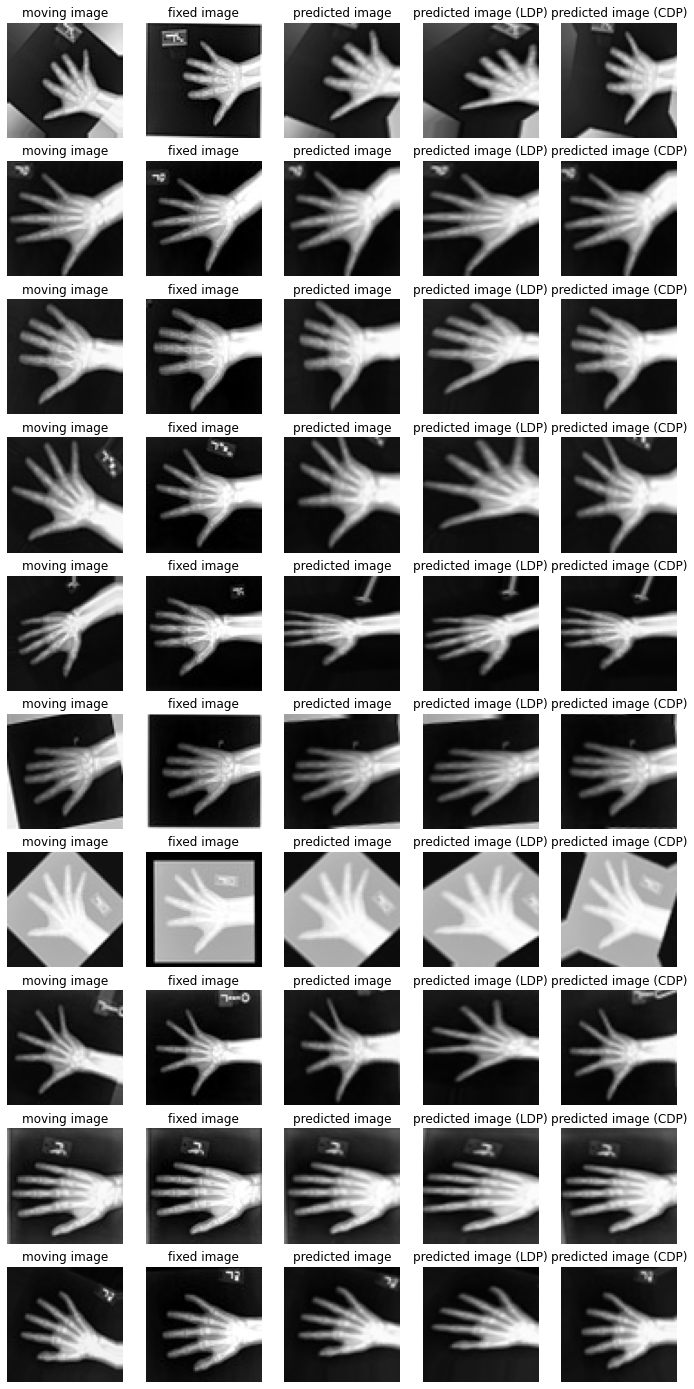

In [25]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()